In [1]:
# PIP Install 
!pip install --upgrade -q transformers
!pip install -q sentencepiece ftfy regex tqdm opencv-python-headless datasets
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q torch torchvision torchaudio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
  Preparing metadata (setup.py) ... done


In [2]:

!kaggle datasets download -d vishnutheepb/msrvtt -p /content/msrvtt_videos --unzip


Dataset URL: https://www.kaggle.com/datasets/vishnutheepb/msrvtt
License(s): unknown
100% 4.26G/4.26G [03:21<00:00, 24.2MB/s]
100% 4.26G/4.26G [03:21<00:00, 22.7MB/s]


In [3]:
import cv2
from PIL import Image
from tqdm import tqdm
import numpy as np
import os

video_dir = "/content/msrvtt_videos/TrainValVideo"

if not os.path.exists(video_dir):
    raise ValueError(f"Video directory {video_dir} does not exist.")

# Frame extraction 
def extract_frames(video_path, num_frames=16, resize=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < num_frames:
        raise ValueError(f"Video {video_path} has only {total_frames} frames, which is less than the required {num_frames} frames.")
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame).resize(resize)
            frames.append(frame)
    cap.release()
    if len(frames) != num_frames:
        raise ValueError(f"Expected {num_frames} frames, but got {len(frames)} from {video_path}")
    return frames


In [4]:
import torch
import clip
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

device = "cuda" if torch.cuda.is_available() else "cpu"

# CLIP model
clip_model, preprocess = clip.load("ViT-B/32", device=device)

clip_model = clip_model.float()

# Preprocessing
preprocess = Compose([
    Resize(224, interpolation=Image.BICUBIC),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
              std=(0.26862954, 0.26130258, 0.27577711)),
])

# Extract features 
def extract_video_features(video_path, num_frames=16):
    frames = extract_frames(video_path, num_frames=num_frames)
    frame_tensors = torch.stack([preprocess(frame) for frame in frames]).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(frame_tensors)
        video_features = image_features.mean(dim=0)
    return video_features.float()

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 141MiB/s]


In [5]:
import cv2
from PIL import Image
from tqdm import tqdm
import numpy as np
import os
import torch
import clip
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

video_dir = "/content/msrvtt_videos/TrainValVideo"

if not os.path.exists(video_dir):
    raise ValueError(f"Video directory {video_dir} does not exist.")

# Frame extraction 
def extract_frames(video_path, num_frames=16, resize=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video {video_path}.")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < num_frames:
        raise ValueError(f"Video {video_path} has only {total_frames} frames, which is less than the required {num_frames} frames.")

    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    frames = []

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame).resize(resize)
            frames.append(frame)
        else:
            print(f"Failed to read frame at index {idx} in {video_path}")
    cap.release()

    if len(frames) != num_frames:
        raise ValueError(f"Expected {num_frames} frames, but got {len(frames)} from {video_path}")
    return frames


device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model, preprocess = clip.load("ViT-B/32", device=device)

clip_model = clip_model.float()

preprocess = Compose([
    Resize(224, interpolation=Image.BICUBIC),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
              std=(0.26862954, 0.26130258, 0.27577711)),
])

# Extract features 
def extract_video_features(video_path, num_frames=16):
    frames = extract_frames(video_path, num_frames=num_frames)
    frame_tensors = torch.stack([preprocess(frame) for frame in frames]).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(frame_tensors)
        video_features = image_features.mean(dim=0)
    return video_features.cpu().float()


In [6]:
import os
import pandas as pd
from datasets import load_dataset

# MSR-VTT
print("Loading dataset...")
dataset = load_dataset("AlexZigma/msr-vtt", split="train")

captions_df = pd.DataFrame(dataset)
captions_df = captions_df[['video_id', 'caption']]

video_dir = "/content/msrvtt_videos/TrainValVideo"

captions_df['video_path'] = captions_df['video_id'].apply(lambda x: os.path.join(video_dir, f"{x}.mp4"))
print(f"video path: {captions_df['video_path']}")

captions_df = captions_df[captions_df['video_path'].apply(os.path.exists)].reset_index(drop=True)


print(f"Total samples: {len(captions_df)}")

train_size = int(0.8 * len(captions_df))
train_captions_df = captions_df.iloc[:train_size]
test_captions_df = captions_df.iloc[train_size:]
print(f"Training samples: {len(train_captions_df)}, Testing samples: {len(test_captions_df)}")

train_captions_df = train_captions_df.sample(n=1000, random_state=42).reset_index(drop=True)
test_captions_df = test_captions_df.sample(n=100, random_state=42).reset_index(drop=True)
print(f"Training samples: {len(train_captions_df)}, Testing samples: {len(test_captions_df)}")


Loading dataset...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/734 [00:00<?, ?B/s]

(…)-00000-of-00001-60e50ff5fbbd1bb5.parquet:   0%|          | 0.00/553k [00:00<?, ?B/s]

(…)-00000-of-00001-01bacdd7064306bc.parquet:   0%|          | 0.00/44.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6513 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/497 [00:00<?, ? examples/s]

video path: 0         /content/msrvtt_videos/TrainValVideo/video0.mp4
1         /content/msrvtt_videos/TrainValVideo/video1.mp4
2        /content/msrvtt_videos/TrainValVideo/video10.mp4
3       /content/msrvtt_videos/TrainValVideo/video100.mp4
4       /content/msrvtt_videos/TrainValVideo/video1000...
                              ...                        
6508    /content/msrvtt_videos/TrainValVideo/video995.mp4
6509    /content/msrvtt_videos/TrainValVideo/video996.mp4
6510    /content/msrvtt_videos/TrainValVideo/video997.mp4
6511    /content/msrvtt_videos/TrainValVideo/video998.mp4
6512    /content/msrvtt_videos/TrainValVideo/video999.mp4
Name: video_path, Length: 6513, dtype: object
Total samples: 6513
Training samples: 5210, Testing samples: 1303
Training samples: 1000, Testing samples: 100


In [7]:
import torch
from torch import nn
from transformers import T5Tokenizer, T5ForConditionalGeneration

device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = T5Tokenizer.from_pretrained("t5-large")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-large")

t5_model = t5_model.float()

class VideoCaptioningModel(nn.Module):
    def __init__(self, clip_feature_dim, decoder_model, hidden_dim=1024, seq_length=10):
        super(VideoCaptioningModel, self).__init__()
        self.decoder = decoder_model
        self.seq_length = seq_length
        self.hidden_dim = hidden_dim

        self.linear = nn.Linear(clip_feature_dim, hidden_dim * seq_length)
        self.relu = nn.ReLU()

        self.proj = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, input_ids, attention_mask, video_features, labels=None):
        video_features = video_features.float()

        mapped_features = self.relu(self.linear(video_features))

        # Reshaping
        total_size = mapped_features.size(0) * self.seq_length * self.hidden_dim
        expected_size = mapped_features.numel()
        if total_size != expected_size:
            raise ValueError(f"Shape mismatch: expected size {total_size}, but got {expected_size}")

        batch_size = mapped_features.size(0)
        mapped_features = mapped_features.view(batch_size, self.seq_length, self.hidden_dim)

        # Encoder attention mask
        encoder_attention_mask = torch.ones(mapped_features.size()[:2], dtype=torch.long).to(device)

        # Token embeddings 
        text_embeddings = self.decoder.get_input_embeddings()(input_ids)

        # Resize video embeddings 
        if mapped_features.size(1) != text_embeddings.size(1):
            mapped_features = torch.nn.functional.interpolate(
                mapped_features.unsqueeze(0),
                size=(text_embeddings.size(1), mapped_features.size(2))
            ).squeeze(0)

        # Concatenate text and video embeddings
        combined_embeddings = torch.cat((text_embeddings, mapped_features), dim=-1)
        combined_embeddings = self.proj(combined_embeddings)  

        # Update attention mask 
        updated_attention_mask = torch.ones(combined_embeddings.size()[:2], dtype=torch.long).to(device)

        encoder_outputs = self.decoder.encoder(
            inputs_embeds=combined_embeddings,
            attention_mask=updated_attention_mask
        )

        decoder_outputs = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_outputs=encoder_outputs,
            labels=labels
        )

        return decoder_outputs


# Initialization
clip_feature_dim = 512  
seq_length = 10
hidden_dim = 1024  
model = VideoCaptioningModel(
    clip_feature_dim=clip_feature_dim,
    decoder_model=t5_model,
    hidden_dim=hidden_dim,
    seq_length=seq_length
).to(device)
model = model.float()

batch = {
    'input_ids': tokenizer.encode("This is a sample caption.", return_tensors="pt").to(device),
    'attention_mask': torch.ones(1, 20).to(device),
    'video_features': torch.randn(1, clip_feature_dim).to(device)
}

# Forward pass with labels
labels = batch['input_ids']
outputs = model(
    input_ids=batch['input_ids'],
    attention_mask=batch['attention_mask'],
    video_features=batch['video_features'],
    labels=labels
)

print(outputs.loss)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


tensor(9.1824, device='cuda:0', grad_fn=<NllLossBackward0>)


In [8]:
max_length = 20  


In [9]:
'''
New Dataset
'''


from torch.utils.data import Dataset, DataLoader

class VideoCaptionDataset(Dataset):
    def __init__(self, captions_df, tokenizer, clip_model, device, num_frames=16, max_length=20):
        self.captions_df = captions_df
        self.tokenizer = tokenizer
        self.clip_model = clip_model
        self.device = device
        self.num_frames = num_frames
        self.max_length = max_length

    def __len__(self):
        return len(self.captions_df)

    def __getitem__(self, idx):
        video_path = self.captions_df.iloc[idx]['video_path']
        caption = self.captions_df.iloc[idx]['caption']

        # Extract video features
        video_features = extract_video_features(video_path, num_frames=self.num_frames)  

        # Tokenize the caption as labels 
        tokens = self.tokenizer(
            caption,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        labels = tokens.input_ids.squeeze(0)  

        input_ids = torch.tensor([[self.tokenizer.pad_token_id]], dtype=torch.long)
        attention_mask = torch.ones_like(input_ids)

        return {
            'video_features': video_features,
            'input_ids': input_ids.squeeze(0),
            'attention_mask': attention_mask.squeeze(0),
            'labels': labels
        }

# Datasets
train_dataset = VideoCaptionDataset(train_captions_df, tokenizer, clip_model, device)
test_dataset = VideoCaptionDataset(test_captions_df, tokenizer, clip_model, device)

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [10]:

batch = next(iter(train_dataloader))

video_features = batch['video_features'].to(device).float()

input_ids = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)
labels = batch['input_ids'].to(device)  

video_features = torch.autograd.Variable(video_features, requires_grad=True)

# Forward pass
model.train()
outputs = model(
    video_features=video_features,
    input_ids=input_ids,
    attention_mask=attention_mask,
    labels=labels
)

# loss gradients
loss = outputs.loss
print(f"Loss requires_grad: {loss.requires_grad}")
try:
    loss.backward()
    print("Backward pass succeeded.")
except Exception as e:
    print(f"Backward pass failed: {e}")


Loss requires_grad: True
Backward pass succeeded.


In [11]:
%%time
import time
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
num_epochs = 50  
train_loss_history = []
test_loss_history = []

 # Training Loop
for epoch in range(num_epochs):
   
    model.train()
    total_loss = 0
    start_time = time.time()
    for batch_idx, batch in enumerate(train_dataloader):
        video_features = batch['video_features'].to(device).float()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            video_features=video_features,
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 100 == 0:
            print(f"Batch {batch_idx+1}/{len(train_dataloader)}, Training Loss: {loss.item()}")

    avg_train_loss = total_loss / len(train_dataloader)
    train_loss_history.append(avg_train_loss)

    # Evaluation phase
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader):
            video_features = batch['video_features'].to(device).float()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass without gradient computation
            outputs = model(
                video_features=video_features,
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            test_loss = outputs.loss
            total_test_loss += test_loss.item()

    avg_test_loss = total_test_loss / len(test_dataloader)
    test_loss_history.append(avg_test_loss)

    end_time = time.time()
    print(f"Epoch {epoch+1}, "
          f"Average Training Loss: {avg_train_loss:.4f}, "
          f"Average Test Loss: {avg_test_loss:.4f}, "
          f"Time Elapsed: {end_time - start_time:.2f} seconds")

print("Training complete.")


Batch 100/125, Training Loss: 1.7182163000106812
Epoch 1, Average Training Loss: 2.4780, Average Test Loss: 1.8215, Time Elapsed: 315.96 seconds
Batch 100/125, Training Loss: 1.5162522792816162
Epoch 2, Average Training Loss: 1.7900, Average Test Loss: 1.8084, Time Elapsed: 316.10 seconds
Batch 100/125, Training Loss: 1.4030518531799316
Epoch 3, Average Training Loss: 1.5640, Average Test Loss: 1.8255, Time Elapsed: 317.16 seconds
Batch 100/125, Training Loss: 1.2126420736312866
Epoch 4, Average Training Loss: 1.3668, Average Test Loss: 1.9108, Time Elapsed: 317.90 seconds
Batch 100/125, Training Loss: 1.0942564010620117
Epoch 5, Average Training Loss: 1.2044, Average Test Loss: 2.0300, Time Elapsed: 316.66 seconds
Batch 100/125, Training Loss: 0.9009187817573547
Epoch 6, Average Training Loss: 1.0527, Average Test Loss: 2.1253, Time Elapsed: 317.98 seconds
Batch 100/125, Training Loss: 0.7554467916488647
Epoch 7, Average Training Loss: 0.9207, Average Test Loss: 2.3033, Time Elapsed: 

KeyboardInterrupt: 

In [14]:
!pip install nltk

In [19]:
def generate_caption(model, tokenizer, video_path, clip_model, device, num_frames=16, max_length=20):
    model.eval()
    with torch.no_grad():
        # Extract video features
        video_features = extract_video_features(video_path, num_frames=num_frames).to(device).float()

        if model.decoder.config.decoder_start_token_id is None:
            model.decoder.config.decoder_start_token_id = tokenizer.pad_token_id

        input_ids = torch.tensor([[tokenizer.pad_token_id]]).to(device)
        attention_mask = torch.ones_like(input_ids).to(device)

        text_embeddings = model.decoder.get_input_embeddings()(input_ids)  

        # Process video features
        mapped_features = model.relu(model.linear(video_features.unsqueeze(0)))
        mapped_features = mapped_features.view(1, model.seq_length, model.hidden_dim)  

        if mapped_features.size(1) != text_embeddings.size(1):
            mapped_features = torch.nn.functional.interpolate(
                mapped_features.unsqueeze(0),
                size=(text_embeddings.size(1), mapped_features.size(2))
            ).squeeze(0)

        # Combine embeddings
        combined_embeddings = torch.cat((text_embeddings, mapped_features), dim=-1)  
        combined_embeddings = model.proj(combined_embeddings) 
        updated_attention_mask = torch.ones(combined_embeddings.size()[:2], dtype=torch.long).to(device)

        encoder_outputs = model.decoder.encoder(
            inputs_embeds=combined_embeddings,
            attention_mask=updated_attention_mask
        )

        # Generate tokens
        generated_ids = model.decoder.generate(
            encoder_outputs=encoder_outputs,
            max_length=64,
            num_beams=3,
            early_stopping=True,
            do_sample=True,
            top_p=0.9,
            top_k=90,
            temperature=0.9,
        )

        caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        return caption

# Inference:
for idx in range(30):
    video_path = test_captions_df.iloc[idx]['video_path']
    true_caption = test_captions_df.iloc[idx]['caption']
    generated_caption = generate_caption(model, tokenizer, video_path, clip_model, device)
    print(f"Video {idx+1}:")
    print(f"True Caption: {true_caption}")
    print(f"Generated Caption: {generated_caption}\n")


Video 1:
True Caption: a wrestler tries to throw another to the ground
Generated Caption: a boy is playing with minecraft lego

Video 2:
True Caption: a boy and a girl are dancing in a car
Generated Caption: a boy is playing with minecraft lego

Video 3:
True Caption: a guy is singing on a hospital bed
Generated Caption: a girl is auditioning for the voice and another is talking about it

Video 4:
True Caption: a girl driving car
Generated Caption: a man is frying something with oil in the frying pan

Video 5:
True Caption: the man driving the car very fastly in the hillstation road and more cars are passing in that road
Generated Caption: a boy is playing with minecraft lego

Video 6:
True Caption: a cartoon character is preparing to fight
Generated Caption: a boy is playing mine craft the video game

Video 7:
True Caption: a guy is singing a song and dancing
Generated Caption: a boy and girl are talking in a room

Video 8:
True Caption: a person explaining a concept in a show
Generat

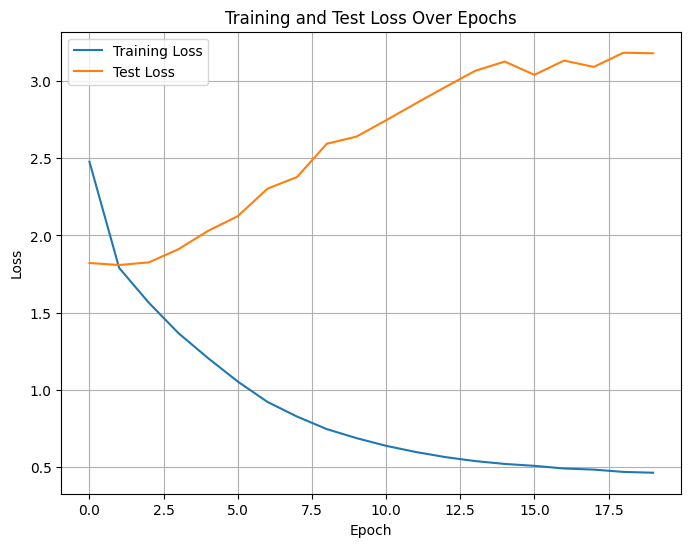

In [15]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.5 MB/s eta 0:00:00
